In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.mixture import GaussianMixture
import scipy.stats as st
from sklearn.model_selection import train_test_split

# Load the CSV files
train_data = pd.read_csv('./data/fashion-mnist_train.csv')

# Separate features (X) and labels (y) for training and testing
X_train_all = train_data.iloc[:, 1:].values  
y_train_all = train_data.iloc[:, 0].values  

# normalize/scale the pixel values to [0, 1]
X_train_all = X_train_all / 255.0


# # Perform 75% train, 25% validation split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train_all, y_train_all, 
#     test_size=0.25, 
#     random_state=42, 
#     stratify=y_train_all
# )

print(len(X_train))
print(len(X_test))

45000
15000


In [10]:
# Fit Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# MDDA - using GMMs per class
n_components = 5  # Chosen based on complexity
gmm_models = {}
for label in np.unique(y_train):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_train[y_train == label])
    gmm_models[label] = gmm

# Predict using MDDA
def predict_mdda(X):
    probs = np.zeros((X.shape[0], len(gmm_models)))
    for label, gmm in gmm_models.items():
        probs[:, label] = gmm.score_samples(X)  # Log-likelihood of the data under each GMM
    return np.argmax(probs, axis=1)

mdda_predictions = predict_mdda(X_test)

In [11]:
import scipy.stats as st

# Function to calculate 95% confidence interval
def compute_confidence_interval(error_rate, n):
    z = 1.96  # For a 95% confidence interval
    ci = z * np.sqrt((error_rate * (1 - error_rate)) / n)
    return error_rate - ci, error_rate + ci

# Overall error rate for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_error_rate = 1 - rf_accuracy
rf_error_rate_ci = compute_confidence_interval(rf_error_rate, len(y_test))

# Overall error rate for MDDA
mdda_accuracy = accuracy_score(y_test, mdda_predictions)
mdda_error_rate = 1 - mdda_accuracy
mdda_error_rate_ci = compute_confidence_interval(mdda_error_rate, len(y_test))

print(f"Random Forest Overall Error Rate: {rf_error_rate:.4f}, 95% CI: {rf_error_rate_ci}")
print(f"MDDA Overall Error Rate: {mdda_error_rate:.4f}, 95% CI: {mdda_error_rate_ci}")

# Class-specific error rates
rf_class_error_rates = []
mdda_class_error_rates = []

for label in np.unique(y_test):
    rf_class_accuracy = accuracy_score(y_test[y_test == label], rf_predictions[y_test == label])
    rf_class_error_rate = 1 - rf_class_accuracy
    rf_class_error_rate_ci = compute_confidence_interval(rf_class_error_rate, np.sum(y_test == label))
    rf_class_error_rates.append((label, rf_class_error_rate, rf_class_error_rate_ci))
    
    mdda_class_accuracy = accuracy_score(y_test[y_test == label], mdda_predictions[y_test == label])
    mdda_class_error_rate = 1 - mdda_class_accuracy
    mdda_class_error_rate_ci = compute_confidence_interval(mdda_class_error_rate, np.sum(y_test == label))
    mdda_class_error_rates.append((label, mdda_class_error_rate, mdda_class_error_rate_ci))

# Display class-specific error rates for both models
print("Class-Specific Error Rates for Random Forest:")
for label, error_rate, ci in rf_class_error_rates:
    print(f"Class {label}: Error Rate: {error_rate:.4f}, 95% CI: {ci}")

print("Class-Specific Error Rates for MDDA:")
for label, error_rate, ci in mdda_class_error_rates:
    print(f"Class {label}: Error Rate: {error_rate:.4f}, 95% CI: {ci}")


Random Forest Overall Error Rate: 0.1204, 95% CI: (np.float64(0.11519205612073244), np.float64(0.12560794387926746))
MDDA Overall Error Rate: 0.2613, 95% CI: (np.float64(0.25430209051057484), np.float64(0.26836457615609177))
Class-Specific Error Rates for Random Forest:
Class 0: Error Rate: 0.1420, 95% CI: (np.float64(0.1243356257286028), np.float64(0.15966437427139724))
Class 1: Error Rate: 0.0340, 95% CI: (np.float64(0.02482854026885581), np.float64(0.04317145973114425))
Class 2: Error Rate: 0.1800, 95% CI: (np.float64(0.16055743226834485), np.float64(0.19944256773165525))
Class 3: Error Rate: 0.0927, 95% CI: (np.float64(0.0779924257295183), np.float64(0.10734090760381505))
Class 4: Error Rate: 0.1647, 95% CI: (np.float64(0.14589757761361236), np.float64(0.1834357557197209))
Class 5: Error Rate: 0.0393, 95% CI: (np.float64(0.02949600472275045), np.float64(0.049170661943916213))
Class 6: Error Rate: 0.4160, 95% CI: (np.float64(0.39105614744537914), np.float64(0.44094385255462093))
Cla

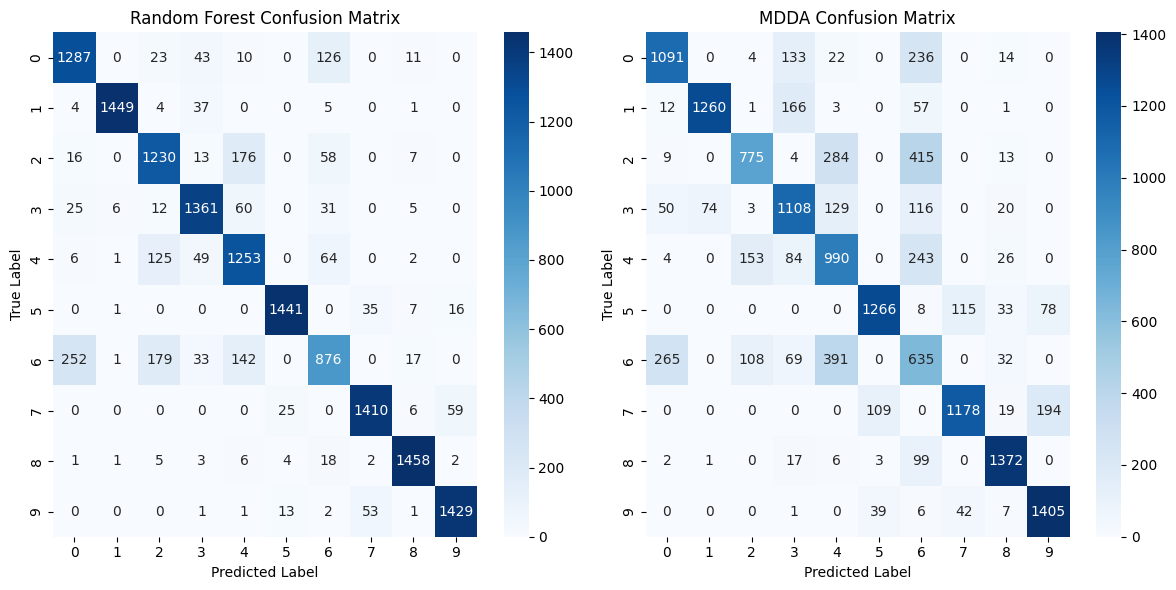

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrices
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
mdda_conf_matrix = confusion_matrix(y_test, mdda_predictions)

# Normalized confusion matrices (scaled by row sums)
rf_conf_matrix_scaled = rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis]
mdda_conf_matrix_scaled = mdda_conf_matrix.astype('float') / mdda_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix.astype('int'), annot=True, fmt='.0f', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# MDDA Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(mdda_conf_matrix.astype('int'), annot=True, fmt='.0f', cmap='Blues')
plt.title('MDDA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

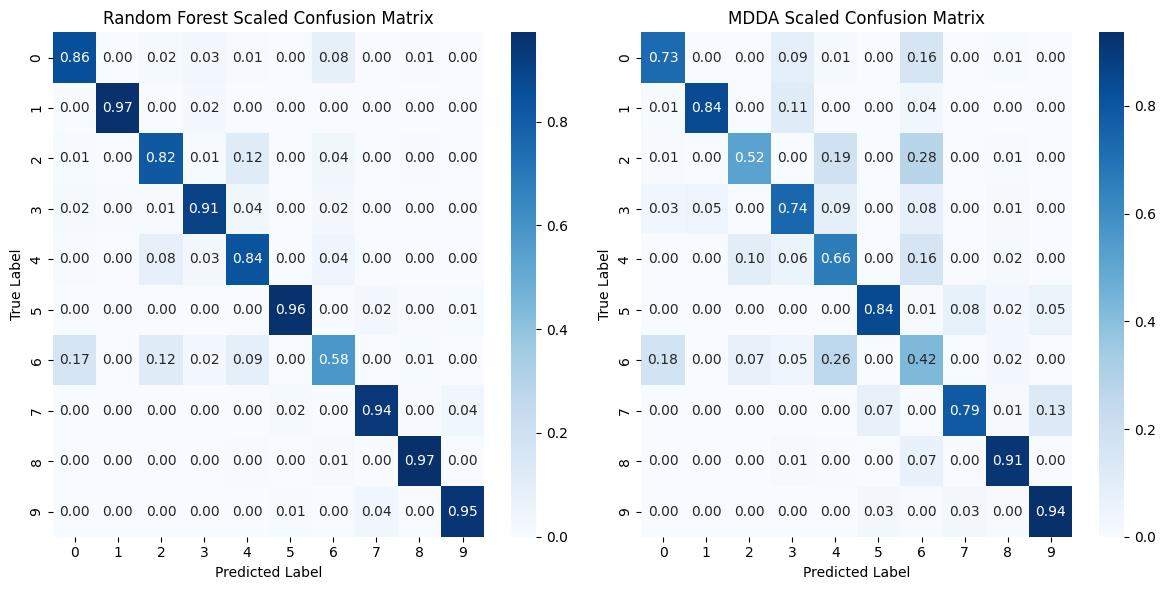

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrices
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
mdda_conf_matrix = confusion_matrix(y_test, mdda_predictions)

# Normalized confusion matrices (scaled by row sums)
rf_conf_matrix_scaled = rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis]
mdda_conf_matrix_scaled = mdda_conf_matrix.astype('float') / mdda_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix_scaled, annot=True, fmt='.2f', cmap='Blues')
plt.title('Random Forest Scaled Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# MDDA Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(mdda_conf_matrix_scaled, annot=True, fmt='.2f', cmap='Blues')
plt.title('MDDA Scaled Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import classification_report, balanced_accuracy_score

# Generate classification reports for Random Forest and MDDA
rf_classification_report = classification_report(y_test, rf_predictions)
mdda_classification_report = classification_report(y_test, mdda_predictions)

# Calculate balanced accuracy
rf_balanced_accuracy = balanced_accuracy_score(y_test, rf_predictions)
mdda_balanced_accuracy = balanced_accuracy_score(y_test, mdda_predictions)

# Print results
print("Random Forest Classification Report:")
print(rf_classification_report)
print(f"Balanced Accuracy for Random Forest: {rf_balanced_accuracy:.4f}")

print("\nMDDA Classification Report:")
print(mdda_classification_report)
print(f"Balanced Accuracy for MDDA: {mdda_balanced_accuracy:.4f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1500
           1       0.99      0.97      0.98      1500
           2       0.78      0.82      0.80      1500
           3       0.88      0.91      0.90      1500
           4       0.76      0.84      0.80      1500
           5       0.97      0.96      0.97      1500
           6       0.74      0.58      0.65      1500
           7       0.94      0.94      0.94      1500
           8       0.96      0.97      0.97      1500
           9       0.95      0.95      0.95      1500

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Balanced Accuracy for Random Forest: 0.8796

MDDA Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1500
           1       0.9